In [1]:
from drug_molecule_generation_with_vae.train import train
from drug_molecule_generation_with_vae.generate import generate
import pandas as pd
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
TRAINING_PATH = "250k_rndm_zinc_drugs_clean_3.csv"
MODEL_PATH = "/tmp/vae_model/"

In [ ]:
train(TRAINING_PATH, MODEL_PATH)

Epoch 1, Loss: 40.437746854119574
Epoch 2, Loss: 35.17505993434501
Epoch 3, Loss: 34.11457056507445
Epoch 4, Loss: 33.498528244190794
Epoch 5, Loss: 33.08337794553934
Epoch 6, Loss: 32.78525546295573
Epoch 7, Loss: 32.56197447994539
Epoch 8, Loss: 32.36649618887669
Epoch 9, Loss: 32.21081992942532
Epoch 10, Loss: 32.072960160217754
Model and information saved in /tmp/vae_model/


In [3]:
# Generate molecules
generated_molecules = generate(1000, MODEL_PATH)

In [5]:
# convert to pandas dataframe
df = pd.DataFrame(generated_molecules)
df

,Generated_SMILES,Validity,QED
0,CC[C@@H](NC(=O)Cc1noc2ccccc1Cl)N2,Valid,0.819124
1,C[C@@H]([NH+](C)C)[C@H](NC(=O)c1ccc(Cl)o1)N(C)...,Valid,0.803994
2,Cc1ccc(C)c2nnc([C@@H]3CCCO[C@@H]2C(F)(F)F)c1SC,Invalid,NaN
3,CN(Cc1csc(Nc2ccc3c(c2)CCO3)ccc1Cl)[C@@H]1CCOC1,Valid,0.807906
4,CCOC(=O)C(C)(C)Oc1ccc(C(=O)N2CCCNC2)cc1Cl,Valid,0.822540
...,...,...,...
995,Cc1c(C)c(CCNC(=O)CCc2ccc(C(=O)N[C@@H](C)c3ccc(...,Invalid,NaN
996,C[O-][C@H](CN1CCN(C(=O)C(C)C)CC1)c1ccccc1,Invalid,NaN
997,CN(Cc1ccc(OC(C)C)s1)[C@H](C)Oc1ccccc1,Valid,0.708057
998,C[NH2+]CC(N)=N1,Invalid,NaN


In [11]:
# Calculate the QEDs from the training set
from rdkit.Chem import Descriptors
from rdkit import Chem 
import numpy as np

def calculate_qed(smiles):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return None
    return Descriptors.qed(m)

training_data = pd.read_csv(TRAINING_PATH)
training_data["QED"] = training_data["SMILES"].apply(calculate_qed)

<Axes: xlabel='count', ylabel='Validity'>

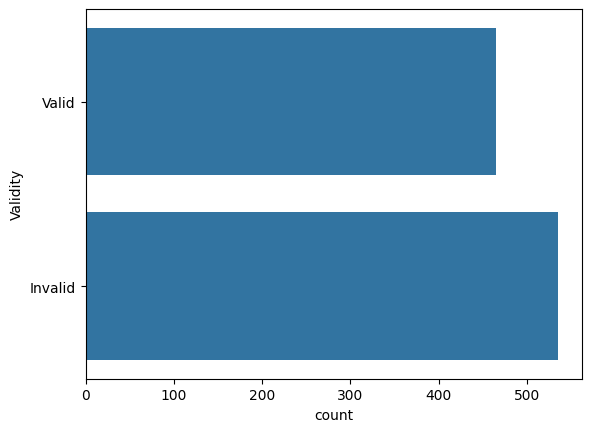

In [6]:
import matplotlib.pyplot as plt
import seaborn

# the df has the columns Generated_SMILES	Validity	Molecular_Weight
# we can plot how many molecules are valid and how many are invalid
seaborn.countplot(df.Validity)

/tmp/ipykernel_312259/3751921277.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(training_data["QED"], label="Training Set", shade=True)
/tmp/ipykernel_312259/3751921277.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(valid_molecules["QED"].dropna(), label="Generated Molecules", shade=True)


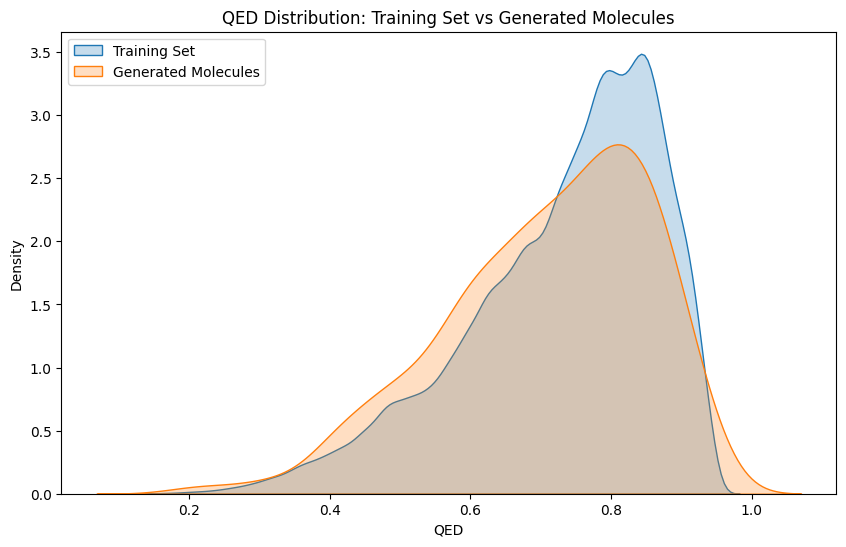

In [20]:
# for all valid molecules we can plot the qed values compared to the training set
valid_molecules = df[df.Validity == "Valid"]
plt.figure(figsize=(10, 6))
seaborn.kdeplot(training_data["QED"], label="Training Set", shade=True)
seaborn.kdeplot(valid_molecules["QED"].dropna(), label="Generated Molecules", shade=True)
plt.xlabel("QED")
plt.ylabel("Density")
plt.title("QED Distribution: Training Set vs Generated Molecules")
plt.legend()
plt.show()


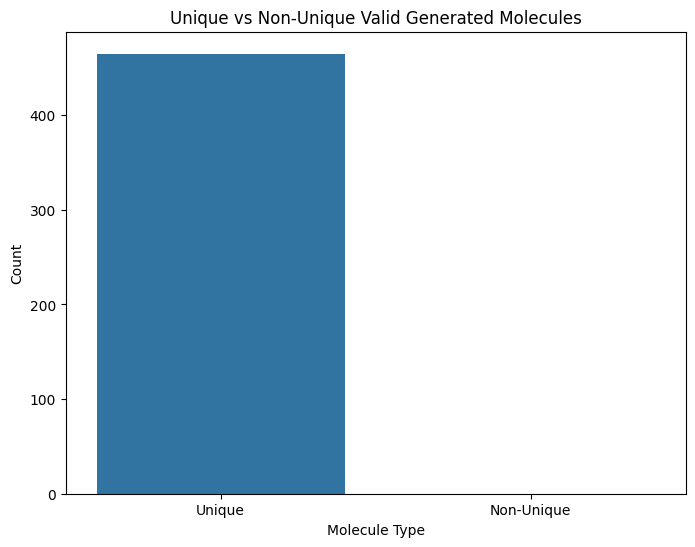

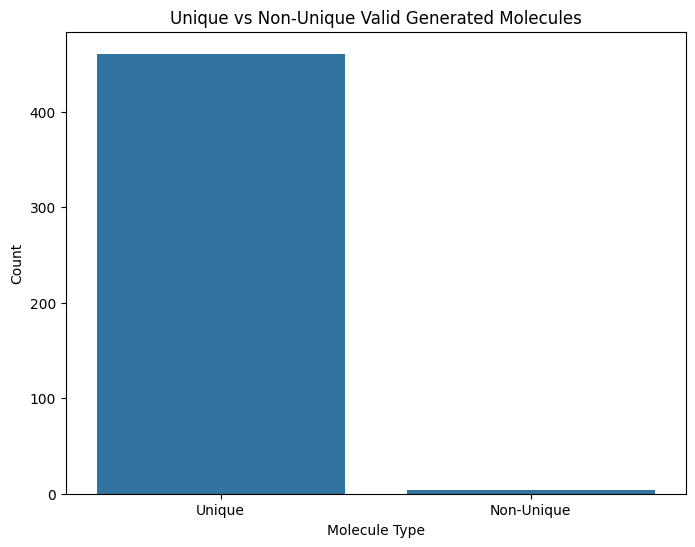

In [24]:
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity

# Filter to include only valid molecules
valid_molecules = df[df['Validity'] == 'Valid']

# Find unique generated molecules
unique_molecules = valid_molecules[~valid_molecules['Generated_SMILES'].isin(training_data['SMILES'])]

# Create a dataframe for plotting
plot_data = pd.DataFrame({
    'Molecule Type': ['Unique', 'Non-Unique'],
    'Count': [len(unique_molecules), len(valid_molecules) - len(unique_molecules)]
})

# Plot the number of unique and non-unique molecules
plt.figure(figsize=(8, 6))
seaborn.barplot(x='Molecule Type', y='Count', data=plot_data)
plt.xlabel('Molecule Type')
plt.ylabel('Count')
plt.title('Unique vs Non-Unique Valid Generated Molecules')
plt.show()
# Calculate fingerprints for the molecules
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

training_fps = training_data['SMILES'].apply(get_fingerprint)
generated_fps = unique_molecules['Generated_SMILES'].apply(get_fingerprint)

# Calculate Tanimoto similarity
def is_unique(fp, fps, threshold=0.7):
    for ref_fp in fps:
        if TanimotoSimilarity(fp, ref_fp) >= threshold:
            return False
    return True

unique_molecules['Is_Unique'] = generated_fps.apply(lambda fp: is_unique(fp, training_fps))

# Update plot data
unique_count = unique_molecules['Is_Unique'].sum()
non_unique_count = len(unique_molecules) - unique_count

plot_data = pd.DataFrame({
    'Molecule Type': ['Unique', 'Non-Unique'],
    'Count': [unique_count, non_unique_count]
})

# Plot the number of unique and non-unique molecules
plt.figure(figsize=(8, 6))
seaborn.barplot(x='Molecule Type', y='Count', data=plot_data)
plt.xlabel('Molecule Type')
plt.ylabel('Count')
plt.title('Unique vs Non-Unique Valid Generated Molecules')
plt.show()